## B-Cell Epitope Prediction using Attention-Based LSTM

### Group 7 Members:

* Donaire, Rudnick James

* Gonzales, Ryan Joseph

* Moncayo, Ethan Andrew

* Pajaro, Randall Joseph

### Project Overview

B-Cells / B-Lymphocytes are a type of white blood cells that functions as a cell that produces antibody molecules which are responsible for humoral immune response (fluid-related substances). 

Epitopes are regions in a protein / peptide that the antigen recognizes. These are areas in which the immune response of our body will recognize and are susceptible for antibodies to lock with (think of it as a lock and key process).

Epitope Prediction is a process in bioinformatics in which it identifies regions of a certain cell where antibodies can latch onto and neutralize its functions. This process can be used to develop epitope-based vaccine of various viruses such as SARS-CoV or H1V1.

The use of Attention-based LSTM to identify these epitope regions in a particular protein sequence requires the task to identify important points within the protein sequence alongside the chemical and structural features of that particular protein and peptide sequeunces. 

This project is based on the study of Toshiaki, N. et al [1] 

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sgt import SGT

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Concatenate, LSTM, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from attention import Attention

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report

#### Loading the Dataset

In [2]:
sars_csv = pd.read_csv('input_sars.csv')
bcell_csv = pd.read_csv('input_bcell.csv')

sars = sars_csv.copy()
b_cell = bcell_csv.copy()

df = pd.concat([sars,b_cell], ignore_index=True)
df.head()

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
0,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1,17,MFIFLLFLTLTSGSDLD,0.887,0.040,1.056,-2.159,5.569763,0.116335,-0.061116,33.205116,0
1,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1,15,MFIFLLFLTLTSGSD,0.869,0.047,1.056,-2.500,5.569763,0.116335,-0.061116,33.205116,0
2,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,2,10,FIFLLFLTL,0.621,0.042,1.148,-7.467,5.569763,0.116335,-0.061116,33.205116,0
3,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,6,20,LFLTLTSGSDLDRCT,1.021,0.230,1.049,0.927,5.569763,0.116335,-0.061116,33.205116,0
4,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,9,25,TLTSGSDLDRCTTFDDV,1.089,0.627,1.015,3.165,5.569763,0.116335,-0.061116,33.205116,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14907 entries, 0 to 14906
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   parent_protein_id    14907 non-null  object 
 1   protein_seq          14907 non-null  object 
 2   start_position       14907 non-null  int64  
 3   end_position         14907 non-null  int64  
 4   peptide_seq          14907 non-null  object 
 5   chou_fasman          14907 non-null  float64
 6   emini                14907 non-null  float64
 7   kolaskar_tongaonkar  14907 non-null  float64
 8   parker               14907 non-null  float64
 9   isoelectric_point    14907 non-null  float64
 10  aromaticity          14907 non-null  float64
 11  hydrophobicity       14907 non-null  float64
 12  stability            14907 non-null  float64
 13  target               14907 non-null  int64  
dtypes: float64(8), int64(3), object(3)
memory usage: 1.6+ MB


In [4]:
df.describe()

,start_position,end_position,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
count,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000,14907.000000
mean,308.845173,319.519420,0.994906,1.082811,1.021808,1.750098,7.015227,0.077143,-0.394063,43.337674,0.271148
std,358.433563,358.647859,0.123656,1.826098,0.053430,1.954424,1.875713,0.026388,0.392808,16.501627,0.444567
min,1.000000,6.000000,0.534000,0.000000,0.838000,-9.029000,3.686096,0.000000,-1.971171,5.448936,0.000000
25%,86.000000,96.000000,0.913000,0.244000,0.987000,0.600000,5.569763,0.062500,-0.600131,31.725753,0.000000
50%,197.000000,208.000000,0.991000,0.551000,1.021000,1.775000,6.447815,0.075949,-0.318259,41.948275,0.000000
75%,400.000000,411.000000,1.073000,1.208500,1.055000,2.960000,8.676575,0.093458,-0.189591,49.101172,1.000000
max,3079.000000,3086.000000,1.546000,40.605000,1.255000,9.120000,12.232727,0.182254,1.267089,137.046667,1.000000


In [5]:
df.isnull().sum()

parent_protein_id      0
protein_seq            0
start_position         0
end_position           0
peptide_seq            0
chou_fasman            0
emini                  0
kolaskar_tongaonkar    0
parker                 0
isoelectric_point      0
aromaticity            0
hydrophobicity         0
stability              0
target                 0
dtype: int64

#### Exploratory Data Analysis

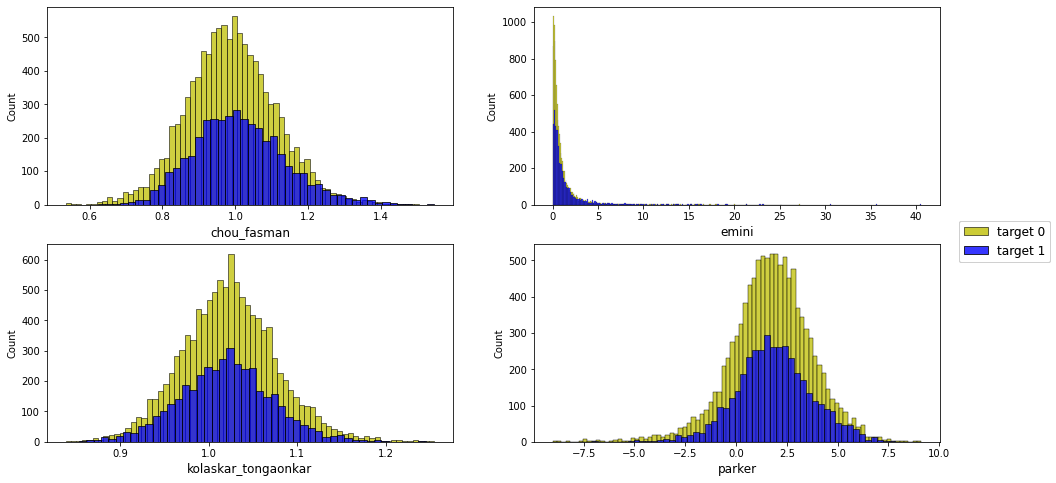

In [38]:
epitopes = df['target'].astype("bool").values
fig, ax = plt.subplots(2, 2, figsize=(16,8))

ax = [x for a in ax for x in a]

for i,name in enumerate(["chou_fasman","emini","kolaskar_tongaonkar","parker"]):
    value = df[name]
    sns.histplot(value[~epitopes],
                 ax = ax[i],
                 color = 'y')
    sns.histplot(value[epitopes],
                 ax = ax[i],
                 color = 'b')
    ax[i].set_xlabel(name, 
                     fontsize=12)
    fig.legend(labels = ["target 0", "target 1"], 
               loc = "right", 
               fontsize=12)

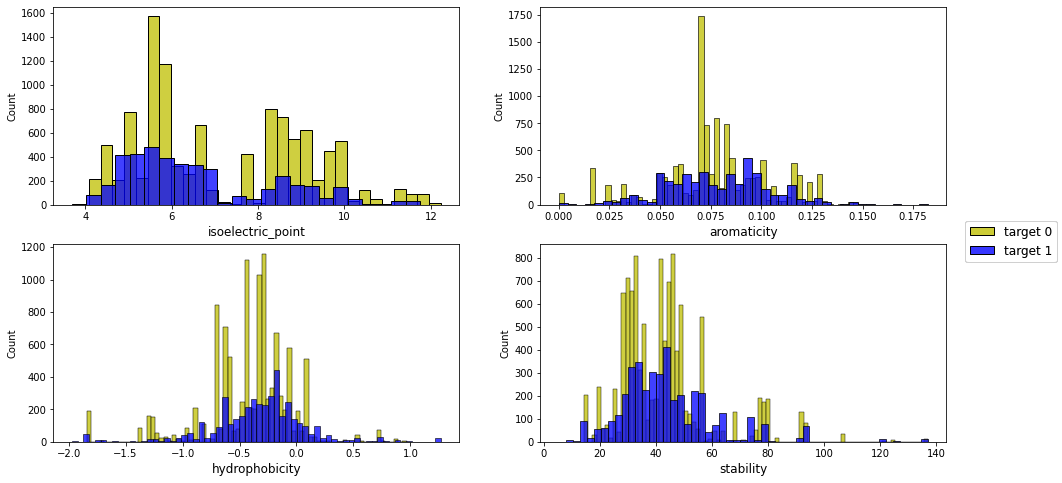

In [7]:
epitopes = df['target'].astype("bool").values
fig, ax = plt.subplots(2, 2, figsize=(16,8))

ax = [x for a in ax for x in a]

for i,name in enumerate(["isoelectric_point","aromaticity","hydrophobicity","stability"]):
    value = df[name]
    sns.histplot(value[~epitopes],
                 ax = ax[i],
                 color = 'y')
    sns.histplot(value[epitopes],
                 ax = ax[i],
                 color = 'b')
    ax[i].set_xlabel(name, 
                     fontsize=12)
    fig.legend(labels = ["target 0", "target 1"], 
               loc = "right", 
               fontsize=12)

As what is shown in here, the distribution of the class per chemical features of a protein and the peptides are equal.

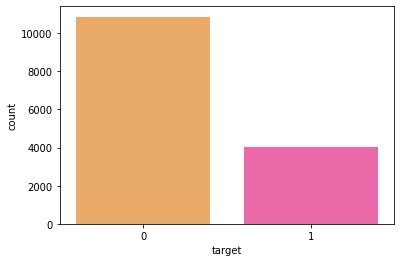

In [8]:
sns.countplot(data = df,
              x = 'target',
              palette = 'spring_r')
plt.show()

The reason for the imbalance number of labels of epitope regions is due to the fact to the total number of proteins present in the dataset. Different proteins have different lengths that may affect the number of eptiope regions present in that sequence (hypothetically).

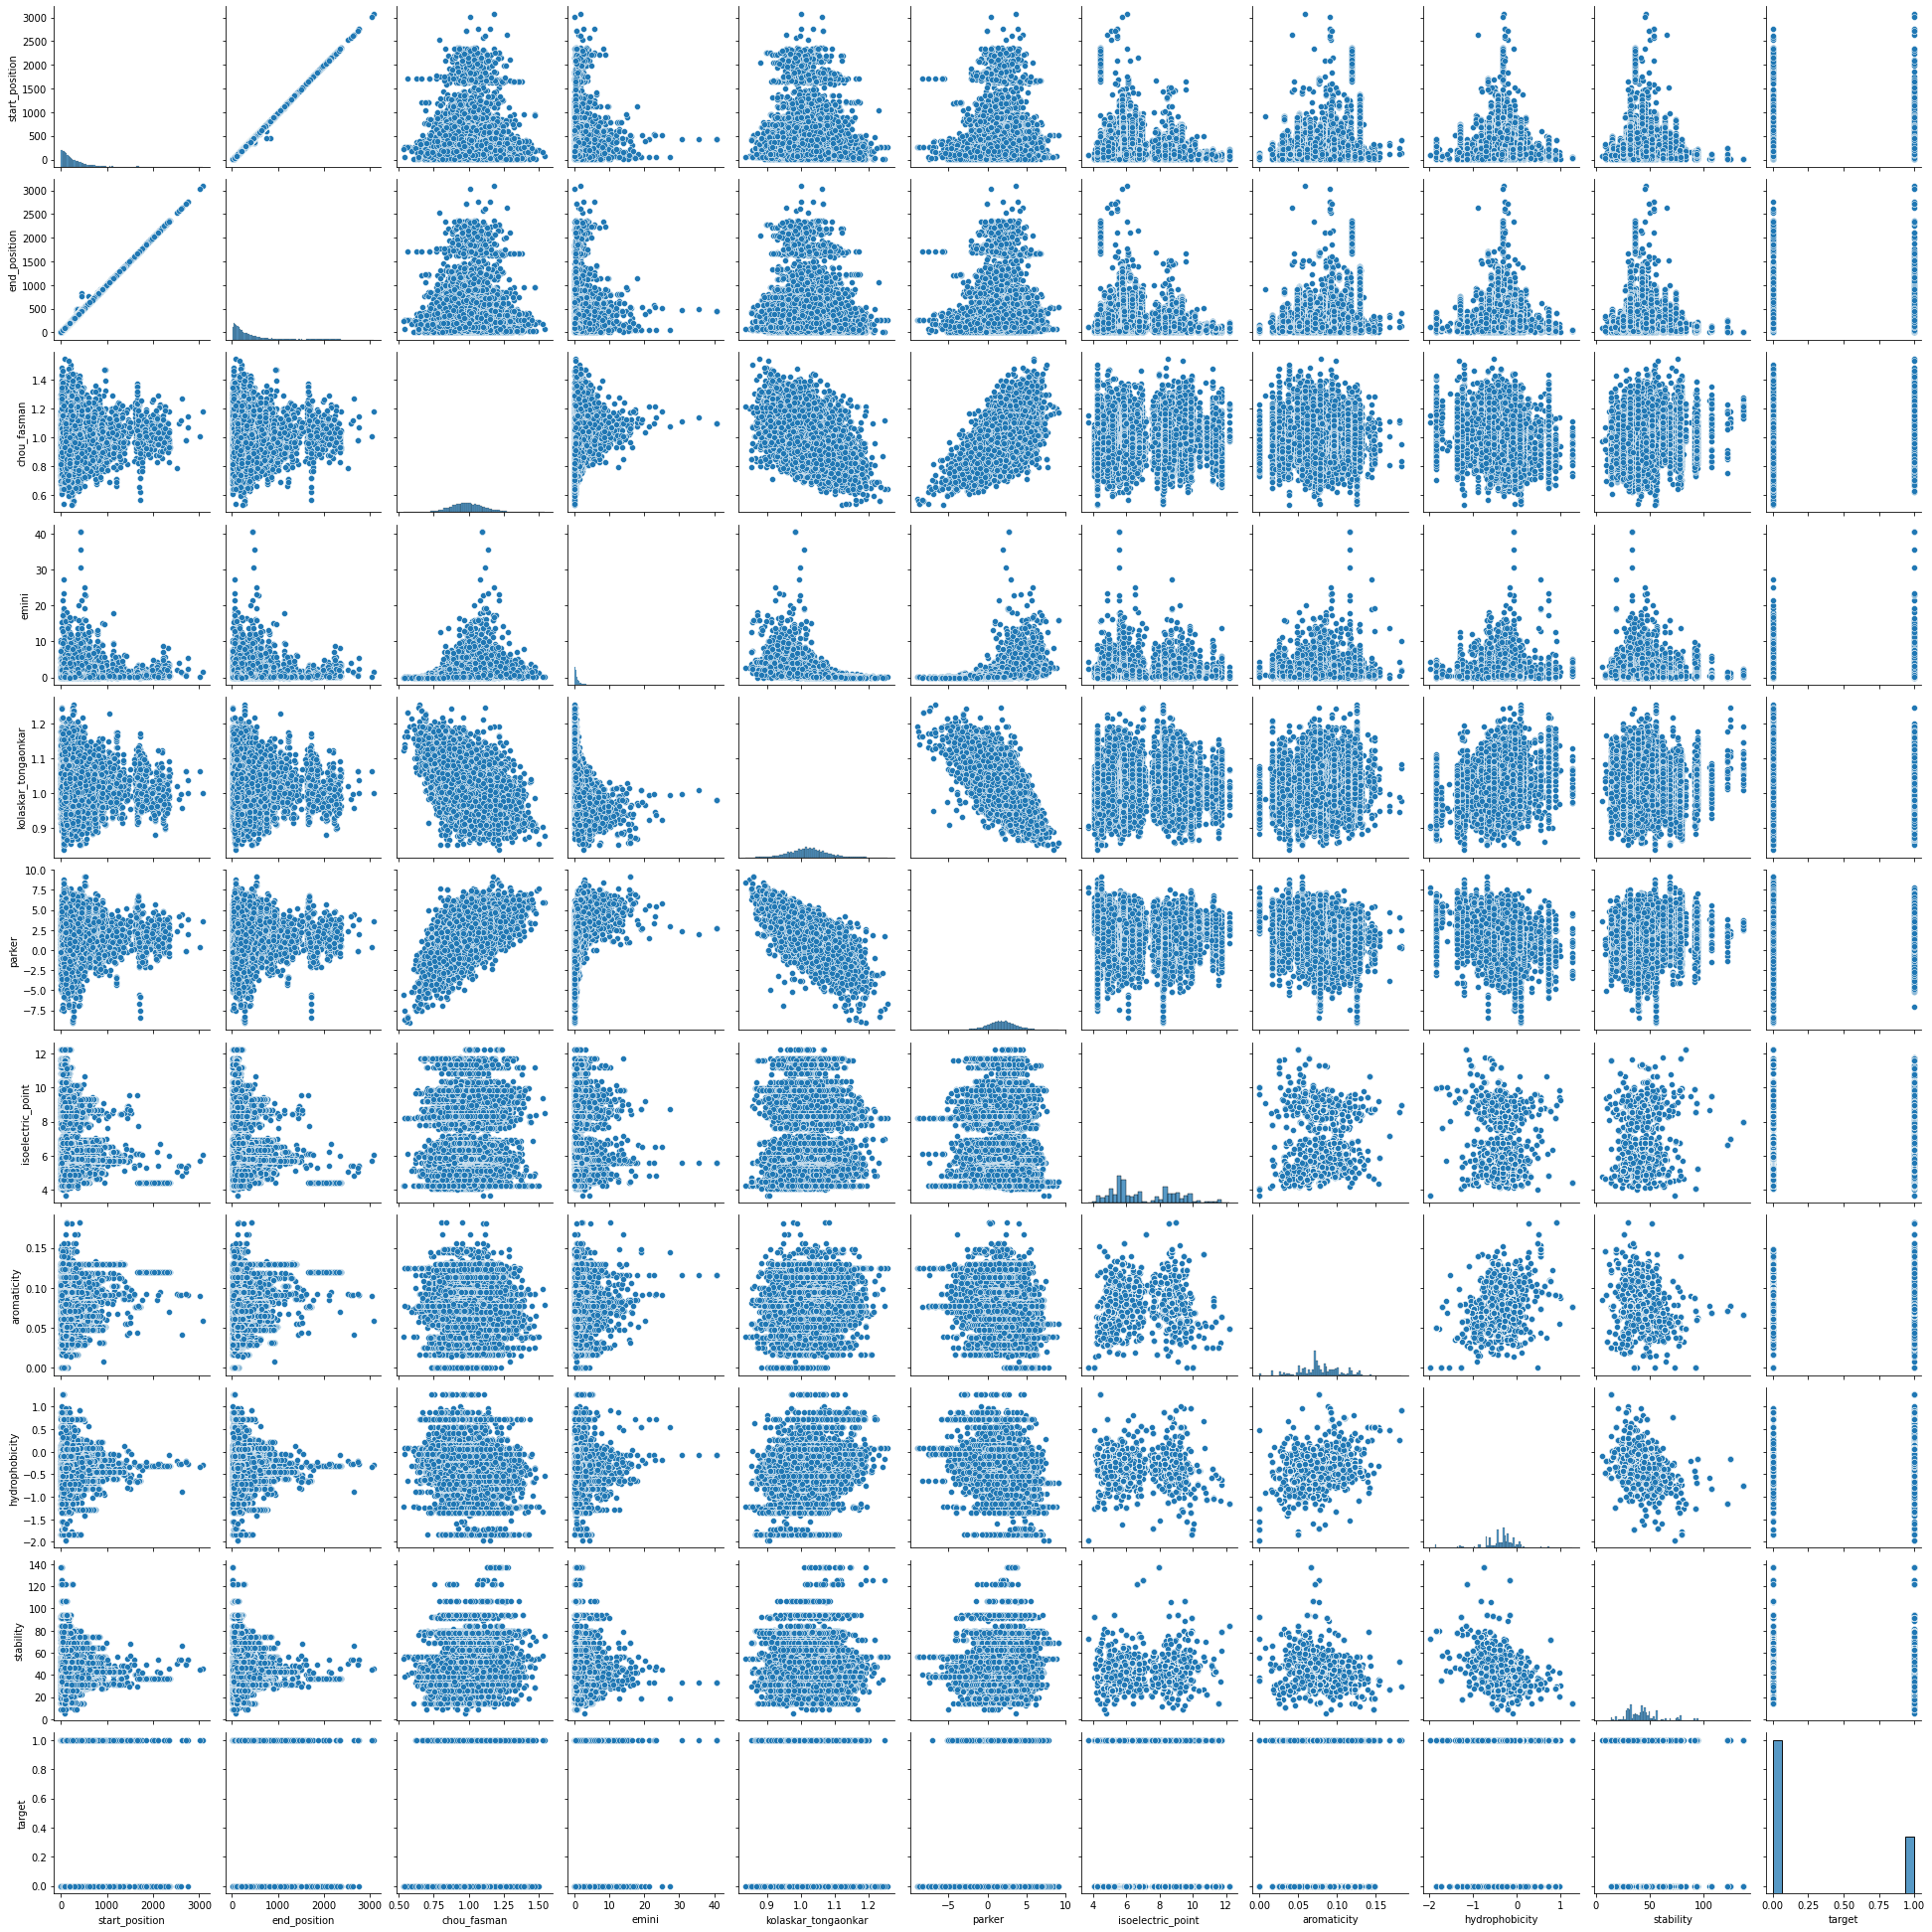

In [9]:
sns.pairplot(data = df)
plt.show()

This pairplot represents the correlation of each chemical and structural features of proteins and peptides in the dataset.

#### Model Creation

In [10]:
# simplifying the dataset

# protein sequence
sequence = df[['parent_protein_id', 'protein_seq', 'peptide_seq']].copy()

# features
features = df.drop(['protein_seq', 'peptide_seq'], axis = 1).copy()

# target
target = df[['parent_protein_id', 'target']].copy()

We will be dividng the dataset into portions: sequences of the proteins present in the dataset (for embedding later on), chemical and structural features of proteins and peptides, and the target class or the ground truth labels of epitope regions.

In [11]:
sequence.head()

,parent_protein_id,protein_seq,peptide_seq
0,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,MFIFLLFLTLTSGSDLD
1,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,MFIFLLFLTLTSGSD
2,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,FIFLLFLTL
3,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,LFLTLTSGSDLDRCT
4,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,TLTSGSDLDRCTTFDDV


In [12]:
features.head()

,parent_protein_id,start_position,end_position,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
0,AAU93319,1,17,0.887,0.040,1.056,-2.159,5.569763,0.116335,-0.061116,33.205116,0
1,AAU93319,1,15,0.869,0.047,1.056,-2.500,5.569763,0.116335,-0.061116,33.205116,0
2,AAU93319,2,10,0.621,0.042,1.148,-7.467,5.569763,0.116335,-0.061116,33.205116,0
3,AAU93319,6,20,1.021,0.230,1.049,0.927,5.569763,0.116335,-0.061116,33.205116,0
4,AAU93319,9,25,1.089,0.627,1.015,3.165,5.569763,0.116335,-0.061116,33.205116,0


In [13]:
target.head()

,parent_protein_id,target
0,AAU93319,0
1,AAU93319,0
2,AAU93319,0
3,AAU93319,0
4,AAU93319,0


#### Embedding of Protein Sequences

The embedding of protein sequences is important for this method. This method is similar to how embedding works in NLP. In this case, the embedding sequence will be based off on the amino acids present in the sequence. These amino acids can be seen in the image below:

<img src = "amino_acids.png">

Each letter present in the sequences represents the amino acid shown in the picture.

In [36]:
corpus = sequence.drop_duplicates(subset = ['parent_protein_id']).reset_index().drop('index', axis = 1)
corpus = corpus[['parent_protein_id', 'protein_seq']].copy()
corpus['protein_seq'] = corpus['protein_seq'].map(list)
corpus.rename(columns = {'parent_protein_id': 'id', 'protein_seq': 'sequence'}, inplace = True)

corpus

,id,sequence
0,AAU93319,"[M, F, I, F, L, L, F, L, T, L, T, S, G, S, D, ..."
1,A2T3T0,"[M, D, V, L, Y, S, L, S, K, T, L, K, D, A, R, ..."
2,F0V2I4,"[M, T, I, H, K, V, A, I, N, G, F, G, R, I, G, ..."
3,O75508,"[M, V, A, T, C, L, Q, V, V, G, F, V, T, S, F, ..."
4,O84462,"[M, T, N, S, I, S, G, Y, Q, P, T, V, T, T, S, ..."
...,...,...
756,Q5F6I1,"[M, T, K, Q, L, K, L, S, A, L, F, V, A, L, L, ..."
757,Q7T9D9,"[M, G, G, L, S, L, L, Q, L, P, R, D, K, F, R, ..."
758,Q81871,"[M, R, P, R, P, I, L, L, L, L, L, M, F, L, P, ..."
759,Q91DE1,"[M, D, R, G, T, R, R, I, W, V, S, Q, N, Q, G, ..."


In [15]:
sgt = SGT(kappa = 10,
          lengthsensitive = False)
embedding = sgt.fit_transform(corpus)
embedding.set_index('id', inplace = True)
embedding

,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)","(A, L)",...,"(Y, M)","(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, Y)"
id,,,,,,,,,,,,,,,,,,,,,
AAU93319,0.206373,0.188073,0.197921,0.205757,0.188173,0.197756,0.076780,0.197342,0.182637,0.188843,...,7.154004e-02,1.901165e-01,0.176172,0.198996,0.202409,0.190768,0.196082,0.191768,0.204729,0.178563
A2T3T0,0.083440,0.094843,0.236770,0.213567,0.085801,0.236914,0.241964,0.230914,0.091894,0.074449,...,3.019743e-05,7.995714e-02,0.081998,0.231885,0.030047,0.260957,0.029773,0.219864,0.013079,0.000031
F0V2I4,0.240478,0.092911,0.210327,0.213199,0.240545,0.225934,0.232824,0.229365,0.213850,0.203761,...,5.005250e-19,2.446945e-01,0.012911,0.036232,0.092489,0.091429,0.004326,0.249794,0.115216,0.251411
O75508,0.211541,0.229098,0.266633,0.036549,0.240204,0.250589,0.260957,0.231432,0.275536,0.239429,...,2.761432e-04,2.126400e-13,0.035944,0.102565,0.266633,0.251411,0.277116,0.245538,0.039172,0.263627
O84462,0.224873,0.030106,0.186145,0.172689,0.186601,0.190224,0.206436,0.170815,0.186824,0.195893,...,1.249665e-09,7.543748e-02,0.200686,0.197929,0.011310,0.185611,0.197078,0.027006,0.031087,0.031261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q5F6I1,0.084115,0.241601,0.082053,0.227828,0.097518,0.218990,0.031116,0.087373,0.244486,0.247684,...,5.492303e-13,2.531515e-01,0.000004,0.089429,0.000595,0.032554,0.262703,0.245974,0.017089,0.000256
Q7T9D9,0.207897,0.031050,0.194902,0.211794,0.242260,0.205042,0.081445,0.193283,0.199705,0.207420,...,4.547478e-03,2.009899e-01,0.027233,0.010379,0.206630,0.203323,0.211375,0.220645,0.222020,0.227923
Q81871,0.210301,0.000528,0.202582,0.211396,0.191542,0.214938,0.213521,0.223836,0.010433,0.197556,...,3.894274e-09,2.370604e-01,0.216465,0.082536,0.225310,0.216287,0.218297,0.196500,0.004419,0.082685


We will then apply PCA in order to reduce the dimensions of the embedded sequence into a 256-dimension vector.

In [16]:
pca = PCA(n_components = 256)
pca_components = pca.fit_transform(embedding)

In [17]:
pca_df = pd.DataFrame(pca_components,
                      columns = ['vector {0}'.format(i + 1) for i in range(256)],)
pca_df['parent_protein_id'] = corpus['id']
pca_cols = pca_df.columns.tolist()
pca_cols = pca_cols[-1:] + pca_cols[:-1]
pca_df = pca_df[pca_cols]
pca_df

,parent_protein_id,vector 1,vector 2,vector 3,vector 4,vector 5,vector 6,vector 7,vector 8,vector 9,...,vector 247,vector 248,vector 249,vector 250,vector 251,vector 252,vector 253,vector 254,vector 255,vector 256
0,AAU93319,-0.857650,0.224306,-0.168453,0.007792,-0.074000,-0.027827,-0.023336,0.001755,0.102413,...,0.047407,-0.040100,0.044507,0.016976,0.013369,0.004139,0.043923,-0.023981,-0.082891,0.012951
1,A2T3T0,-0.217129,-0.305087,0.132406,0.237793,0.038138,-0.289895,-0.051764,0.051721,0.064773,...,0.043796,-0.000989,-0.049091,0.071537,-0.005425,0.038019,-0.001597,0.061279,0.024878,0.030903
2,F0V2I4,0.056037,-0.195550,-0.121842,0.208691,-0.401361,0.049827,0.204537,-0.096208,-0.391866,...,-0.010134,-0.041115,0.018243,-0.119777,-0.013433,0.000734,0.096365,0.014271,-0.004899,0.018738
3,O75508,0.497248,0.516343,0.186537,0.421227,-0.169211,-0.204186,0.072386,-0.044273,0.210057,...,-0.052123,0.015277,0.095925,0.029617,0.064624,0.051846,0.037560,-0.027295,-0.019692,0.163262
4,O84462,-0.126953,-0.325322,-0.042521,0.052661,0.093576,0.003861,0.262026,-0.273735,0.035819,...,-0.022385,0.010140,0.045513,0.063799,-0.041397,-0.109963,-0.004417,-0.029668,0.019886,0.064172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,Q5F6I1,0.429767,-0.230684,-0.026051,-0.134467,-0.198217,0.060651,0.084128,-0.057682,-0.007400,...,0.004246,-0.014872,0.004008,0.036957,-0.105019,0.061482,-0.083328,-0.086151,-0.014969,-0.045102
757,Q7T9D9,-0.616245,0.141540,-0.013215,0.077082,-0.110707,0.140049,0.107807,-0.148898,-0.151833,...,-0.026066,0.056325,-0.015396,-0.005497,0.013227,-0.086804,-0.028640,0.019257,0.016028,-0.049436
758,Q81871,-0.449741,-0.075700,0.393529,0.182627,0.054733,-0.022795,-0.051007,0.065229,-0.005635,...,0.025171,0.028787,0.013048,-0.090229,-0.055872,0.026986,0.121340,0.074417,-0.073447,-0.131286
759,Q91DE1,-0.496172,-0.408107,0.172195,-0.027548,0.086922,-0.033614,0.000651,0.252728,-0.181319,...,-0.044702,0.028033,0.013764,-0.036661,0.029055,0.015517,0.053689,-0.069230,-0.029129,-0.026337


In [39]:
merged = pd.merge(features, pca_df, how = 'inner', on = 'parent_protein_id')

# separating the dataset to two inputs: vectors and features

# vectors
columns = list(features.columns)
vectors_input = merged.drop(columns, axis = 1)

# features
features_input = merged[columns].copy()
features_input.drop('target', axis = 1, inplace = True)

#### Model Testing

We will scale the chemical and structural features of the proteins via StandardScaler

In [20]:
# scaling features_input values
scaler = StandardScaler()

scaling = features_input.drop(['parent_protein_id', 'start_position', 'end_position'], axis = 1).copy()

scaled = scaler.fit_transform(scaling)

x = pd.DataFrame(scaled)
x.insert(0, 'start_position', features_input['start_position'])
x.insert(1, 'end_position', features['end_position'])

rename = list(features.columns)[2:]

for i in range(8):
    x.rename(columns = {i: rename[i]}, inplace = True)

y = merged['target']

This will be the model that is going to be used for the Attention-based LSTM architecture. It will consist of:

* an LSTM layer
* an Attention layer
* concatenated to a FCL that accepts the vectors of protein sequences and the chemical and structural features of the protein

In [22]:
# model architecture

# input layer
vector_input = Input((256, 1))
feature_input = Input((10,))

# lstm layer
lstm_layer_1 = LSTM(128, return_sequences = True)(vector_input)
lstm_dropout = Dropout(0.6)(lstm_layer_1)
lstm_attention = Attention(32)(lstm_dropout)

# fork layer
concat_layer = Concatenate()([feature_input, lstm_attention])

# fully-connected layer
dense_1 = Dense(200, kernel_initializer = 'normal', activation = 'relu')(concat_layer)
batch_normal_1 = BatchNormalization(momentum = 0.6)(dense_1)
dropout_1 = Dropout(0.3)(batch_normal_1)
dense_2 = Dense(100, kernel_initializer = 'uniform', activation = 'relu')(dropout_1)
batch_normal_2 = BatchNormalization(momentum = 0.6)(dense_2)
dropout_2 = Dropout(0.3)(batch_normal_2)
dense_3 = Dense(40, kernel_initializer = 'uniform', activation = 'relu')(dropout_2)
batch_normal_3 = BatchNormalization(momentum = 0.6)(dense_3)
droput_3 = Dropout(0.3)(batch_normal_3)
output = Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid')(droput_3)

# defining model
model = Model(inputs = [vector_input, feature_input], outputs = output)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 128)     66560       input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 128)     0           lstm[0][0]                       
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 128)          0           dropout[0][0]                    
______________________________________________________________________________________________

In [24]:
early_stop = EarlyStopping(monitor = 'loss',
                           patience = 2,
                           verbose = 1)

hist = model.fit([vectors_input, x], y,
                 epochs = 100,
                 batch_size = 32,
                 callbacks = early_stop)

Epoch 1/100
466/466 [==============================] - 85s 174ms/step - loss: 0.6538 - accuracy: 0.6409
Epoch 2/100
466/466 [==============================] - 83s 177ms/step - loss: 0.5875 - accuracy: 0.7296
Epoch 3/100
466/466 [==============================] - 78s 166ms/step - loss: 0.5813 - accuracy: 0.7281
Epoch 4/100
466/466 [==============================] - 77s 165ms/step - loss: 0.5787 - accuracy: 0.7230
Epoch 5/100
466/466 [==============================] - 81s 175ms/step - loss: 0.5643 - accuracy: 0.7332
Epoch 6/100
466/466 [==============================] - 81s 175ms/step - loss: 0.5748 - accuracy: 0.7247
Epoch 7/100
466/466 [==============================] - 79s 170ms/step - loss: 0.5706 - accuracy: 0.7288
Epoch 8/100
466/466 [==============================] - 80s 172ms/step - loss: 0.5698 - accuracy: 0.7262
Epoch 9/100
466/466 [==============================] - 80s 171ms/step - loss: 0.5679 - accuracy: 0.7307
Epoch 10/100
466/466 [==============================] - 80s 173m

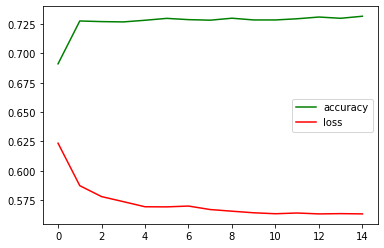

In [25]:
plt.plot(hist.history['accuracy'],
         label = 'accuracy',
         color = 'green')
plt.plot(hist.history['loss'],
         label = 'loss',
         color = 'red')
plt.legend()
plt.show()

As shown in the graph, the accuracy provided by the model is around 72%, which is somewhat close to the study that this project was based on.

### Model Predictions

We will be using the model to a dataset that contains a protein sequence of the Covid with no particular labels to it. 

In [26]:
covid_data = pd.read_csv('input_covid.csv')
covid_data

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability
0,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,1,5,MGILP,0.948,0.280,1.033,-2.720,6.03595,0.10929,-0.138642,31.377603
1,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,2,6,GILPS,1.114,0.379,1.070,-0.580,6.03595,0.10929,-0.138642,31.377603
2,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,3,7,ILPSP,1.106,0.592,1.108,-1.300,6.03595,0.10929,-0.138642,31.377603
3,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,4,8,LPSPG,1.324,0.836,1.053,1.440,6.03595,0.10929,-0.138642,31.377603
4,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,5,9,PSPGM,1.326,1.004,0.968,2.440,6.03595,0.10929,-0.138642,31.377603
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20307,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,1258,1277,YVRKDGEWVLLSTFLGHHHH,0.947,0.406,1.063,0.155,6.03595,0.10929,-0.138642,31.377603
20308,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,1259,1278,VRKDGEWVLLSTFLGHHHHH,0.937,0.353,1.061,0.355,6.03595,0.10929,-0.138642,31.377603
20309,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,1260,1279,RKDGEWVLLSTFLGHHHHHH,0.960,0.647,1.047,0.645,6.03595,0.10929,-0.138642,31.377603
20310,6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...,1261,1280,KDGEWVLLSTFLGHHHHHHH,0.960,0.449,1.058,0.540,6.03595,0.10929,-0.138642,31.377603


In [27]:
corpus_copy = corpus.copy()

sequence_pred = covid_data[['parent_protein_id', 'protein_seq', 'peptide_seq']].copy()

corpus_prediction = sequence_pred.drop_duplicates(subset = ['parent_protein_id']).reset_index().drop('index', axis = 1)
corpus_prediction = corpus_prediction[['parent_protein_id', 'protein_seq']].copy()
corpus_prediction['protein_seq'] = corpus_prediction['protein_seq'].map(list)
corpus_prediction.rename(columns = {'parent_protein_id': 'id', 'protein_seq': 'sequence'}, inplace = True)

corpus_combine = pd.concat([corpus_copy, corpus_prediction], ignore_index = True)
corpus_combine

,id,sequence
0,AAU93319,"[M, F, I, F, L, L, F, L, T, L, T, S, G, S, D, ..."
1,A2T3T0,"[M, D, V, L, Y, S, L, S, K, T, L, K, D, A, R, ..."
2,F0V2I4,"[M, T, I, H, K, V, A, I, N, G, F, G, R, I, G, ..."
3,O75508,"[M, V, A, T, C, L, Q, V, V, G, F, V, T, S, F, ..."
4,O84462,"[M, T, N, S, I, S, G, Y, Q, P, T, V, T, T, S, ..."
...,...,...
757,Q7T9D9,"[M, G, G, L, S, L, L, Q, L, P, R, D, K, F, R, ..."
758,Q81871,"[M, R, P, R, P, I, L, L, L, L, L, M, F, L, P, ..."
759,Q91DE1,"[M, D, R, G, T, R, R, I, W, V, S, Q, N, Q, G, ..."
760,Q9QZS0,"[M, H, S, K, T, A, P, R, F, L, V, F, L, L, L, ..."


In [28]:
embedding_pred = sgt.fit_transform(corpus_combine)
embedding_pred.set_index('id', inplace = True)
embedding_pred

,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)","(A, L)",...,"(Y, M)","(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, Y)"
id,,,,,,,,,,,,,,,,,,,,,
AAU93319,0.206373,0.188073,0.197921,0.205757,0.188173,0.197756,0.076780,0.197342,0.182637,0.188843,...,7.154004e-02,1.901165e-01,0.176172,0.198996,0.202409,0.190768,0.196082,0.191768,0.204729,0.178563
A2T3T0,0.083440,0.094843,0.236770,0.213567,0.085801,0.236914,0.241964,0.230914,0.091894,0.074449,...,3.019743e-05,7.995714e-02,0.081998,0.231885,0.030047,0.260957,0.029773,0.219864,0.013079,0.000031
F0V2I4,0.240478,0.092911,0.210327,0.213199,0.240545,0.225934,0.232824,0.229365,0.213850,0.203761,...,5.005250e-19,2.446945e-01,0.012911,0.036232,0.092489,0.091429,0.004326,0.249794,0.115216,0.251411
O75508,0.211541,0.229098,0.266633,0.036549,0.240204,0.250589,0.260957,0.231432,0.275536,0.239429,...,2.761432e-04,2.126400e-13,0.035944,0.102565,0.266633,0.251411,0.277116,0.245538,0.039172,0.263627
O84462,0.224873,0.030106,0.186145,0.172689,0.186601,0.190224,0.206436,0.170815,0.186824,0.195893,...,1.249665e-09,7.543748e-02,0.200686,0.197929,0.011310,0.185611,0.197078,0.027006,0.031087,0.031261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q7T9D9,0.207897,0.031050,0.194902,0.211794,0.242260,0.205042,0.081445,0.193283,0.199705,0.207420,...,4.547478e-03,2.009899e-01,0.027233,0.010379,0.206630,0.203323,0.211375,0.220645,0.222020,0.227923
Q81871,0.210301,0.000528,0.202582,0.211396,0.191542,0.214938,0.213521,0.223836,0.010433,0.197556,...,3.894274e-09,2.370604e-01,0.216465,0.082536,0.225310,0.216287,0.218297,0.196500,0.004419,0.082685
Q91DE1,0.200040,0.270063,0.181221,0.200017,0.212107,0.217553,0.198275,0.215787,0.207465,0.191638,...,8.280586e-02,2.141321e-01,0.224638,0.211458,0.201769,0.072611,0.221598,0.077521,0.033537,0.209710


In [29]:
pca_two = PCA(n_components = 256)
pca_components_two = pca_two.fit_transform(embedding_pred)

In [30]:
pca_df_two = pd.DataFrame(pca_components_two,
                      columns = ['vector {0}'.format(i + 1) for i in range(256)],)
pca_df_two['parent_protein_id'] = corpus_combine['id']
pca_cols_two = pca_df_two.columns.tolist()
pca_cols_two = pca_cols_two[-1:] + pca_cols_two[:-1]
vectors_test = pca_df_two[pca_cols_two]
vectors_test

,parent_protein_id,vector 1,vector 2,vector 3,vector 4,vector 5,vector 6,vector 7,vector 8,vector 9,...,vector 247,vector 248,vector 249,vector 250,vector 251,vector 252,vector 253,vector 254,vector 255,vector 256
0,AAU93319,-0.857394,0.224392,-0.168704,0.007802,-0.074179,-0.027565,-0.022686,0.001680,0.101648,...,-0.005867,0.026888,-0.012136,-0.056220,-0.055030,-0.078443,-0.036353,0.042788,0.056309,-0.006960
1,A2T3T0,-0.216444,-0.305076,0.131948,0.237809,0.037898,-0.289527,-0.050431,0.051556,0.063627,...,0.174366,-0.038859,-0.058242,-0.019931,-0.072080,-0.021944,-0.061295,0.011392,-0.023172,-0.068248
2,F0V2I4,0.056537,-0.195339,-0.122498,0.208712,-0.401638,0.050397,0.205176,-0.096382,-0.391788,...,-0.065918,0.089309,-0.030116,0.041348,-0.015254,0.004701,0.123352,-0.027321,0.068752,-0.068604
3,O75508,0.498165,0.516291,0.186692,0.421232,-0.169206,-0.204092,0.072664,-0.044207,0.209789,...,0.012466,0.030275,0.049473,0.066605,0.095031,-0.052060,-0.030223,-0.029706,0.088096,-0.127372
4,O84462,-0.126038,-0.325361,-0.042634,0.052664,0.093479,0.004309,0.262125,-0.273640,0.036297,...,-0.032400,0.050009,0.046720,-0.120347,-0.002523,-0.070328,-0.113304,0.024994,-0.134323,0.068982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,Q7T9D9,-0.615274,0.141318,-0.012800,0.077076,-0.110639,0.140104,0.107494,-0.148902,-0.151453,...,-0.039243,0.009033,0.007188,-0.053222,-0.047293,-0.019363,0.052511,0.028147,-0.007871,0.077469
758,Q81871,-0.448200,-0.076245,0.394367,0.182614,0.054977,-0.023165,-0.051550,0.065281,-0.005426,...,0.054189,0.010955,0.079040,0.078582,-0.039158,-0.085056,0.040000,-0.011890,0.018883,0.033795
759,Q91DE1,-0.494827,-0.408481,0.172668,-0.027558,0.087075,-0.033784,0.000368,0.252705,-0.181045,...,0.032339,0.026808,0.002834,0.028057,-0.053095,-0.003750,0.056969,0.080267,0.022171,0.019044
760,Q9QZS0,-0.231725,0.343501,-0.000753,-0.077711,-0.048163,-0.086270,0.174309,-0.008313,0.277553,...,-0.008506,-0.086322,0.024625,-0.032304,0.051740,-0.015062,0.019048,0.071789,-0.012761,-0.020706


In [31]:
covid_features = covid_data.drop(['protein_seq', 'peptide_seq'], axis = 1).copy()

merged_input = pd.merge(vectors_test, covid_features, how = 'inner', on = 'parent_protein_id')

covid_vectors = merged_input[vectors_test.columns.tolist()].copy()
covid_vectors.drop('parent_protein_id', axis = 1, inplace = True)

covid_features = merged_input[covid_features.columns.tolist()].copy()
covid_features.drop('parent_protein_id', axis = 1, inplace = True)

In [32]:
predictions = model.predict([covid_vectors, covid_features])

In [33]:
results = [1 if value > 0.5 else 0 for value in predictions]

In [34]:
values, counts = np.unique(results, return_counts = True)

In [35]:
covid_results = covid_data.copy()
covid_results['predictions'] = results

print('Peptide Sequences of Covid Strain in identifying locations of interest:\n')
for peptide in covid_results[covid_results['predictions'] == 1]['peptide_seq']:
    print('\t-{0}'.format(peptide))

Peptide Sequences of Covid Strain in identifying locations of interest:

	-MGILP
	-GILPS
	-ILPSP
	-LPSPG
	-PSPGM
	-SPGMP
	-PGMPA
	-GMPAL
	-MPALL
	-PALLS
	-ALLSL
	-LLSLV
	-LSLVS
	-SLVSL
	-LVSLL
	-VSLLS
	-SLLSV
	-LLSVL
	-LSVLL
	-SVLLM
	-VLLMG
	-LLMGC
	-LMGCV
	-MGCVA
	-GCVAE
	-CVAET
	-VAETG
	-AETGT
	-ETGTQ
	-TGTQC
	-GTQCV
	-TQCVN
	-QCVNL
	-CVNLT
	-VNLTT
	-NLTTR
	-LTTRT
	-TTRTQ
	-TRTQL
	-RTQLP
	-TQLPP
	-QLPPA
	-LPPAY
	-PPAYT
	-PAYTN
	-AYTNS
	-YTNSF
	-TNSFT
	-NSFTR
	-SFTRG
	-FTRGV
	-TRGVY
	-RGVYY
	-GVYYP
	-VYYPD
	-YYPDK
	-YPDKV
	-PDKVF
	-DKVFR
	-KVFRS
	-VFRSS
	-FRSSV
	-RSSVL
	-SSVLH
	-SVLHS
	-VLHST
	-LHSTQ
	-HSTQD
	-STQDL
	-TQDLF
	-QDLFL
	-DLFLP
	-LFLPF
	-FLPFF
	-LPFFS
	-PFFSN
	-FFSNV
	-FSNVT
	-SNVTW
	-NVTWF
	-VTWFH
	-TWFHA
	-WFHAI
	-FHAIH
	-HAIHV
	-AIHVS
	-IHVSG
	-HVSGT
	-VSGTN
	-SGTNG
	-GTNGT
	-TNGTK
	-NGTKR
	-GTKRF
	-TKRFD
	-KRFDN
	-RFDNP
	-FDNPV
	-DNPVL
	-NPVLP
	-PVLPF
	-VLPFN
	-LPFND
	-PFNDG
	-FNDGV
	-NDGVY
	-DGVYF
	-GVYFA
	-VYFAS
	-YFAST
	-FASTE
	-ASTEK
	-STEKS
	-TEKSN
	-EKSNI
	-KSNII

	-NPVLPF
	-PVLPFN
	-VLPFND
	-LPFNDG
	-PFNDGV
	-FNDGVY
	-NDGVYF
	-DGVYFA
	-GVYFAS
	-VYFAST
	-YFASTE
	-FASTEK
	-ASTEKS
	-STEKSN
	-TEKSNI
	-EKSNII
	-KSNIIR
	-SNIIRG
	-NIIRGW
	-IIRGWI
	-IRGWIF
	-RGWIFG
	-GWIFGT
	-WIFGTT
	-IFGTTL
	-FGTTLD
	-GTTLDS
	-TTLDSK
	-TLDSKT
	-LDSKTQ
	-DSKTQS
	-SKTQSL
	-KTQSLL
	-TQSLLI
	-QSLLIV
	-SLLIVN
	-LLIVNN
	-LIVNNA
	-IVNNAT
	-VNNATN
	-NNATNV
	-NATNVV
	-ATNVVI
	-TNVVIK
	-NVVIKV
	-VVIKVC
	-VIKVCE
	-IKVCEF
	-KVCEFQ
	-VCEFQF
	-CEFQFC
	-EFQFCN
	-FQFCND
	-QFCNDP
	-FCNDPF
	-CNDPFL
	-NDPFLG
	-DPFLGV
	-PFLGVY
	-FLGVYY
	-LGVYYH
	-GVYYHK
	-VYYHKN
	-YYHKNN
	-YHKNNK
	-HKNNKS
	-KNNKSW
	-NNKSWM
	-NKSWME
	-KSWMES
	-SWMESE
	-WMESEF
	-MESEFR
	-ESEFRV
	-SEFRVY
	-EFRVYS
	-FRVYSS
	-RVYSSA
	-VYSSAN
	-YSSANN
	-SSANNC
	-SANNCT
	-ANNCTF
	-NNCTFE
	-NCTFEY
	-CTFEYV
	-TFEYVS
	-FEYVSQ
	-EYVSQP
	-YVSQPF
	-VSQPFL
	-SQPFLM
	-QPFLMD
	-PFLMDL
	-FLMDLE
	-LMDLEG
	-MDLEGK
	-DLEGKQ
	-LEGKQG
	-EGKQGN
	-GKQGNF
	-KQGNFK
	-QGNFKN
	-GNFKNL
	-NFKNLR
	-FKNLRE
	-KNLREF
	-NLREFV
	-LREFVF
	-REFVFK
	-EFVFKN
	

	-RKRISNC
	-KRISNCV
	-RISNCVA
	-ISNCVAD
	-SNCVADY
	-NCVADYS
	-CVADYSV
	-VADYSVL
	-ADYSVLY
	-DYSVLYN
	-YSVLYNS
	-SVLYNSA
	-VLYNSAS
	-LYNSASF
	-YNSASFS
	-NSASFST
	-SASFSTF
	-ASFSTFK
	-SFSTFKC
	-FSTFKCY
	-STFKCYG
	-TFKCYGV
	-FKCYGVS
	-KCYGVSP
	-CYGVSPT
	-YGVSPTK
	-GVSPTKL
	-VSPTKLN
	-SPTKLND
	-PTKLNDL
	-TKLNDLC
	-KLNDLCF
	-LNDLCFT
	-NDLCFTN
	-DLCFTNV
	-LCFTNVY
	-CFTNVYA
	-FTNVYAD
	-TNVYADS
	-NVYADSF
	-VYADSFV
	-YADSFVI
	-ADSFVIR
	-DSFVIRG
	-SFVIRGD
	-FVIRGDE
	-VIRGDEV
	-IRGDEVR
	-RGDEVRQ
	-GDEVRQI
	-DEVRQIA
	-EVRQIAP
	-VRQIAPG
	-RQIAPGQ
	-QIAPGQT
	-IAPGQTG
	-APGQTGK
	-PGQTGKI
	-GQTGKIA
	-QTGKIAD
	-TGKIADY
	-GKIADYN
	-KIADYNY
	-IADYNYK
	-ADYNYKL
	-DYNYKLP
	-YNYKLPD
	-NYKLPDD
	-YKLPDDF
	-KLPDDFT
	-LPDDFTG
	-PDDFTGC
	-DDFTGCV
	-DFTGCVI
	-FTGCVIA
	-TGCVIAW
	-GCVIAWN
	-CVIAWNS
	-VIAWNSN
	-IAWNSNN
	-AWNSNNL
	-WNSNNLD
	-NSNNLDS
	-SNNLDSK
	-NNLDSKV
	-NLDSKVG
	-LDSKVGG
	-DSKVGGN
	-SKVGGNY
	-KVGGNYN
	-VGGNYNY
	-GGNYNYL
	-GNYNYLY
	-NYNYLYR
	-YNYLYRL
	-NYLYRLF
	-YLYRLFR
	-LYRLFRK
	-YRLFRKS
	-RLFRKSN


	-LTESNKKF
	-TESNKKFL
	-ESNKKFLP
	-SNKKFLPF
	-NKKFLPFQ
	-KKFLPFQQ
	-KFLPFQQF
	-FLPFQQFG
	-LPFQQFGR
	-PFQQFGRD
	-FQQFGRDI
	-QQFGRDIA
	-QFGRDIAD
	-FGRDIADT
	-GRDIADTT
	-RDIADTTD
	-DIADTTDA
	-IADTTDAV
	-ADTTDAVR
	-DTTDAVRD
	-TTDAVRDP
	-TDAVRDPQ
	-DAVRDPQT
	-AVRDPQTL
	-VRDPQTLE
	-RDPQTLEI
	-DPQTLEIL
	-PQTLEILD
	-QTLEILDI
	-TLEILDIT
	-LEILDITP
	-EILDITPC
	-ILDITPCS
	-LDITPCSF
	-DITPCSFG
	-ITPCSFGG
	-TPCSFGGV
	-PCSFGGVS
	-CSFGGVSV
	-SFGGVSVI
	-FGGVSVIT
	-GGVSVITP
	-GVSVITPG
	-VSVITPGT
	-SVITPGTN
	-VITPGTNT
	-ITPGTNTS
	-TPGTNTSN
	-PGTNTSNE
	-GTNTSNEV
	-TNTSNEVA
	-NTSNEVAV
	-TSNEVAVL
	-SNEVAVLY
	-NEVAVLYQ
	-EVAVLYQD
	-VAVLYQDV
	-AVLYQDVN
	-VLYQDVNC
	-LYQDVNCT
	-YQDVNCTE
	-QDVNCTEV
	-DVNCTEVP
	-VNCTEVPV
	-NCTEVPVA
	-CTEVPVAI
	-TEVPVAIH
	-EVPVAIHA
	-VPVAIHAD
	-PVAIHADQ
	-VAIHADQL
	-AIHADQLT
	-IHADQLTP
	-HADQLTPT
	-ADQLTPTW
	-DQLTPTWR
	-QLTPTWRV
	-LTPTWRVY
	-TPTWRVYS
	-PTWRVYST
	-TWRVYSTG
	-WRVYSTGS
	-RVYSTGSN
	-VYSTGSNV
	-YSTGSNVF
	-STGSNVFQ
	-TGSNVFQT
	-GSNVFQTR
	-SNVFQTRA
	-NVFQTRAG
	-VFQTRAGC

	-QNVLYENQK
	-NVLYENQKL
	-VLYENQKLI
	-LYENQKLIA
	-YENQKLIAN
	-ENQKLIANQ
	-NQKLIANQF
	-QKLIANQFN
	-KLIANQFNS
	-LIANQFNSA
	-IANQFNSAI
	-ANQFNSAIG
	-NQFNSAIGK
	-QFNSAIGKI
	-FNSAIGKIQ
	-NSAIGKIQD
	-SAIGKIQDS
	-AIGKIQDSL
	-IGKIQDSLS
	-GKIQDSLSS
	-KIQDSLSST
	-IQDSLSSTA
	-QDSLSSTAS
	-DSLSSTASA
	-SLSSTASAL
	-LSSTASALG
	-SSTASALGK
	-STASALGKL
	-TASALGKLQ
	-ASALGKLQD
	-SALGKLQDV
	-ALGKLQDVV
	-LGKLQDVVN
	-GKLQDVVNQ
	-KLQDVVNQN
	-LQDVVNQNA
	-QDVVNQNAQ
	-DVVNQNAQA
	-VVNQNAQAL
	-VNQNAQALN
	-NQNAQALNT
	-QNAQALNTL
	-NAQALNTLV
	-AQALNTLVK
	-QALNTLVKQ
	-ALNTLVKQL
	-LNTLVKQLS
	-NTLVKQLSS
	-TLVKQLSSN
	-LVKQLSSNF
	-VKQLSSNFG
	-KQLSSNFGA
	-QLSSNFGAI
	-LSSNFGAIS
	-SSNFGAISS
	-SNFGAISSV
	-NFGAISSVL
	-FGAISSVLN
	-GAISSVLND
	-AISSVLNDI
	-ISSVLNDIL
	-SSVLNDILS
	-SVLNDILSR
	-VLNDILSRL
	-LNDILSRLD
	-NDILSRLDP
	-DILSRLDPP
	-ILSRLDPPE
	-LSRLDPPEA
	-SRLDPPEAE
	-RLDPPEAEV
	-LDPPEAEVQ
	-DPPEAEVQI
	-PPEAEVQID
	-PEAEVQIDR
	-EAEVQIDRL
	-AEVQIDRLI
	-EVQIDRLIT
	-VQIDRLITG
	-QIDRLITGR
	-IDRLITGRL
	-DRLITGRLQ
	-RLITGRLQS
	-LI

	-NEVAKNLNES
	-EVAKNLNESL
	-VAKNLNESLI
	-AKNLNESLID
	-KNLNESLIDL
	-NLNESLIDLQ
	-LNESLIDLQE
	-NESLIDLQEL
	-ESLIDLQELG
	-SLIDLQELGK
	-LIDLQELGKY
	-IDLQELGKYE
	-DLQELGKYEQ
	-LQELGKYEQY
	-QELGKYEQYI
	-ELGKYEQYIK
	-LGKYEQYIKG
	-GKYEQYIKGS
	-KYEQYIKGSG
	-YEQYIKGSGR
	-EQYIKGSGRE
	-QYIKGSGREN
	-YIKGSGRENL
	-IKGSGRENLY
	-KGSGRENLYF
	-GSGRENLYFQ
	-SGRENLYFQG
	-GRENLYFQGG
	-RENLYFQGGG
	-ENLYFQGGGG
	-NLYFQGGGGS
	-LYFQGGGGSG
	-YFQGGGGSGY
	-FQGGGGSGYI
	-QGGGGSGYIP
	-GGGGSGYIPE
	-GGGSGYIPEA
	-GGSGYIPEAP
	-GSGYIPEAPR
	-SGYIPEAPRD
	-GYIPEAPRDG
	-YIPEAPRDGQ
	-IPEAPRDGQA
	-PEAPRDGQAY
	-EAPRDGQAYV
	-APRDGQAYVR
	-PRDGQAYVRK
	-RDGQAYVRKD
	-DGQAYVRKDG
	-GQAYVRKDGE
	-QAYVRKDGEW
	-AYVRKDGEWV
	-YVRKDGEWVL
	-VRKDGEWVLL
	-RKDGEWVLLS
	-KDGEWVLLST
	-DGEWVLLSTF
	-GEWVLLSTFL
	-EWVLLSTFLG
	-WVLLSTFLGH
	-VLLSTFLGHH
	-LLSTFLGHHH
	-LSTFLGHHHH
	-STFLGHHHHH
	-TFLGHHHHHH
	-FLGHHHHHHH
	-LGHHHHHHHH
	-MGILPSPGMPA
	-GILPSPGMPAL
	-ILPSPGMPALL
	-LPSPGMPALLS
	-PSPGMPALLSL
	-SPGMPALLSLV
	-PGMPALLSLVS
	-GMPALLSLVSL
	-MPALLSLVSLL
	-P

	-PGDSSSGWTAGA
	-GDSSSGWTAGAA
	-DSSSGWTAGAAA
	-SSSGWTAGAAAY
	-SSGWTAGAAAYY
	-SGWTAGAAAYYV
	-GWTAGAAAYYVG
	-WTAGAAAYYVGY
	-TAGAAAYYVGYL
	-AGAAAYYVGYLQ
	-GAAAYYVGYLQP
	-AAAYYVGYLQPR
	-AAYYVGYLQPRT
	-AYYVGYLQPRTF
	-YYVGYLQPRTFL
	-YVGYLQPRTFLL
	-VGYLQPRTFLLK
	-GYLQPRTFLLKY
	-YLQPRTFLLKYN
	-LQPRTFLLKYNE
	-QPRTFLLKYNEN
	-PRTFLLKYNENG
	-RTFLLKYNENGT
	-TFLLKYNENGTI
	-FLLKYNENGTIT
	-LLKYNENGTITD
	-LKYNENGTITDA
	-KYNENGTITDAV
	-YNENGTITDAVD
	-NENGTITDAVDC
	-ENGTITDAVDCA
	-NGTITDAVDCAL
	-GTITDAVDCALD
	-TITDAVDCALDP
	-ITDAVDCALDPL
	-TDAVDCALDPLS
	-DAVDCALDPLSE
	-AVDCALDPLSET
	-VDCALDPLSETK
	-DCALDPLSETKC
	-CALDPLSETKCT
	-ALDPLSETKCTL
	-LDPLSETKCTLK
	-DPLSETKCTLKS
	-PLSETKCTLKSF
	-LSETKCTLKSFT
	-SETKCTLKSFTV
	-ETKCTLKSFTVE
	-TKCTLKSFTVEK
	-KCTLKSFTVEKG
	-CTLKSFTVEKGI
	-TLKSFTVEKGIY
	-LKSFTVEKGIYQ
	-KSFTVEKGIYQT
	-SFTVEKGIYQTS
	-FTVEKGIYQTSN
	-TVEKGIYQTSNF
	-VEKGIYQTSNFR
	-EKGIYQTSNFRV
	-KGIYQTSNFRVQ
	-GIYQTSNFRVQP
	-IYQTSNFRVQPT
	-YQTSNFRVQPTE
	-QTSNFRVQPTES
	-TSNFRVQPTESI
	-SNFRVQPTESIV
	-NFRVQPTE

	-LLHAPATVCGPKK
	-LHAPATVCGPKKS
	-HAPATVCGPKKST
	-APATVCGPKKSTN
	-PATVCGPKKSTNL
	-ATVCGPKKSTNLV
	-TVCGPKKSTNLVK
	-VCGPKKSTNLVKN
	-CGPKKSTNLVKNK
	-GPKKSTNLVKNKC
	-PKKSTNLVKNKCV
	-KKSTNLVKNKCVN
	-KSTNLVKNKCVNF
	-STNLVKNKCVNFN
	-TNLVKNKCVNFNF
	-NLVKNKCVNFNFN
	-LVKNKCVNFNFNG
	-VKNKCVNFNFNGL
	-KNKCVNFNFNGLT
	-NKCVNFNFNGLTG
	-KCVNFNFNGLTGT
	-CVNFNFNGLTGTG
	-VNFNFNGLTGTGV
	-NFNFNGLTGTGVL
	-FNFNGLTGTGVLT
	-NFNGLTGTGVLTE
	-FNGLTGTGVLTES
	-NGLTGTGVLTESN
	-GLTGTGVLTESNK
	-LTGTGVLTESNKK
	-TGTGVLTESNKKF
	-GTGVLTESNKKFL
	-TGVLTESNKKFLP
	-GVLTESNKKFLPF
	-VLTESNKKFLPFQ
	-LTESNKKFLPFQQ
	-TESNKKFLPFQQF
	-ESNKKFLPFQQFG
	-SNKKFLPFQQFGR
	-NKKFLPFQQFGRD
	-KKFLPFQQFGRDI
	-KFLPFQQFGRDIA
	-FLPFQQFGRDIAD
	-LPFQQFGRDIADT
	-PFQQFGRDIADTT
	-FQQFGRDIADTTD
	-QQFGRDIADTTDA
	-QFGRDIADTTDAV
	-FGRDIADTTDAVR
	-GRDIADTTDAVRD
	-RDIADTTDAVRDP
	-DIADTTDAVRDPQ
	-IADTTDAVRDPQT
	-ADTTDAVRDPQTL
	-DTTDAVRDPQTLE
	-TTDAVRDPQTLEI
	-TDAVRDPQTLEIL
	-DAVRDPQTLEILD
	-AVRDPQTLEILDI
	-VRDPQTLEILDIT
	-RDPQTLEILDITP
	-DPQTLEILDITPC
	-PQTLEI

	-ARDLICAQKFNGLT
	-RDLICAQKFNGLTV
	-DLICAQKFNGLTVL
	-LICAQKFNGLTVLP
	-ICAQKFNGLTVLPP
	-CAQKFNGLTVLPPL
	-AQKFNGLTVLPPLL
	-QKFNGLTVLPPLLT
	-KFNGLTVLPPLLTD
	-FNGLTVLPPLLTDE
	-NGLTVLPPLLTDEM
	-GLTVLPPLLTDEMI
	-LTVLPPLLTDEMIA
	-TVLPPLLTDEMIAQ
	-VLPPLLTDEMIAQY
	-LPPLLTDEMIAQYT
	-PPLLTDEMIAQYTS
	-PLLTDEMIAQYTSA
	-LLTDEMIAQYTSAL
	-LTDEMIAQYTSALL
	-TDEMIAQYTSALLA
	-DEMIAQYTSALLAG
	-EMIAQYTSALLAGT
	-MIAQYTSALLAGTI
	-IAQYTSALLAGTIT
	-AQYTSALLAGTITS
	-QYTSALLAGTITSG
	-YTSALLAGTITSGW
	-TSALLAGTITSGWT
	-SALLAGTITSGWTF
	-ALLAGTITSGWTFG
	-LLAGTITSGWTFGA
	-LAGTITSGWTFGAG
	-AGTITSGWTFGAGA
	-GTITSGWTFGAGAA
	-TITSGWTFGAGAAL
	-ITSGWTFGAGAALQ
	-TSGWTFGAGAALQI
	-SGWTFGAGAALQIP
	-GWTFGAGAALQIPF
	-WTFGAGAALQIPFA
	-TFGAGAALQIPFAM
	-FGAGAALQIPFAMQ
	-GAGAALQIPFAMQM
	-AGAALQIPFAMQMA
	-GAALQIPFAMQMAY
	-AALQIPFAMQMAYR
	-ALQIPFAMQMAYRF
	-LQIPFAMQMAYRFN
	-QIPFAMQMAYRFNG
	-IPFAMQMAYRFNGI
	-PFAMQMAYRFNGIG
	-FAMQMAYRFNGIGV
	-AMQMAYRFNGIGVT
	-MQMAYRFNGIGVTQ
	-QMAYRFNGIGVTQN
	-MAYRFNGIGVTQNV
	-AYRFNGIGVTQNVL
	-YRFNGIGVTQNV

	-REGVFVSNGTHWFVT
	-EGVFVSNGTHWFVTQ
	-GVFVSNGTHWFVTQR
	-VFVSNGTHWFVTQRN
	-FVSNGTHWFVTQRNF
	-VSNGTHWFVTQRNFY
	-SNGTHWFVTQRNFYE
	-NGTHWFVTQRNFYEP
	-GTHWFVTQRNFYEPQ
	-THWFVTQRNFYEPQI
	-HWFVTQRNFYEPQII
	-WFVTQRNFYEPQIIT
	-FVTQRNFYEPQIITT
	-VTQRNFYEPQIITTD
	-TQRNFYEPQIITTDN
	-QRNFYEPQIITTDNT
	-RNFYEPQIITTDNTF
	-NFYEPQIITTDNTFV
	-FYEPQIITTDNTFVS
	-YEPQIITTDNTFVSG
	-EPQIITTDNTFVSGN
	-PQIITTDNTFVSGNC
	-QIITTDNTFVSGNCD
	-IITTDNTFVSGNCDV
	-ITTDNTFVSGNCDVV
	-TTDNTFVSGNCDVVI
	-TDNTFVSGNCDVVIG
	-DNTFVSGNCDVVIGI
	-NTFVSGNCDVVIGIV
	-TFVSGNCDVVIGIVN
	-FVSGNCDVVIGIVNN
	-VSGNCDVVIGIVNNT
	-SGNCDVVIGIVNNTV
	-GNCDVVIGIVNNTVY
	-NCDVVIGIVNNTVYD
	-CDVVIGIVNNTVYDP
	-DVVIGIVNNTVYDPL
	-VVIGIVNNTVYDPLQ
	-VIGIVNNTVYDPLQP
	-IGIVNNTVYDPLQPE
	-GIVNNTVYDPLQPEL
	-IVNNTVYDPLQPELD
	-VNNTVYDPLQPELDS
	-NNTVYDPLQPELDSF
	-NTVYDPLQPELDSFK
	-TVYDPLQPELDSFKE
	-VYDPLQPELDSFKEE
	-YDPLQPELDSFKEEL
	-DPLQPELDSFKEELD
	-PLQPELDSFKEELDK
	-LQPELDSFKEELDKY
	-QPELDSFKEELDKYF
	-PELDSFKEELDKYFK
	-ELDSFKEELDKYFKN
	-LDSFKEELDKYFKNH
	-DSFKEELD

	-KNLREFVFKNIDGYFKI
	-NLREFVFKNIDGYFKIY
	-LREFVFKNIDGYFKIYS
	-REFVFKNIDGYFKIYSK
	-EFVFKNIDGYFKIYSKH
	-FVFKNIDGYFKIYSKHT
	-VFKNIDGYFKIYSKHTP
	-FKNIDGYFKIYSKHTPI
	-KNIDGYFKIYSKHTPIN
	-NIDGYFKIYSKHTPINL
	-IDGYFKIYSKHTPINLV
	-DGYFKIYSKHTPINLVR
	-GYFKIYSKHTPINLVRD
	-YFKIYSKHTPINLVRDL
	-FKIYSKHTPINLVRDLP
	-KIYSKHTPINLVRDLPQ
	-IYSKHTPINLVRDLPQG
	-YSKHTPINLVRDLPQGF
	-SKHTPINLVRDLPQGFS
	-KHTPINLVRDLPQGFSA
	-HTPINLVRDLPQGFSAL
	-TPINLVRDLPQGFSALE
	-PINLVRDLPQGFSALEP
	-INLVRDLPQGFSALEPL
	-NLVRDLPQGFSALEPLV
	-LVRDLPQGFSALEPLVD
	-VRDLPQGFSALEPLVDL
	-RDLPQGFSALEPLVDLP
	-DLPQGFSALEPLVDLPI
	-LPQGFSALEPLVDLPIG
	-PQGFSALEPLVDLPIGI
	-QGFSALEPLVDLPIGIN
	-GFSALEPLVDLPIGINI
	-FSALEPLVDLPIGINIT
	-SALEPLVDLPIGINITR
	-ALEPLVDLPIGINITRF
	-LEPLVDLPIGINITRFQ
	-EPLVDLPIGINITRFQT
	-PLVDLPIGINITRFQTL
	-LVDLPIGINITRFQTLL
	-VDLPIGINITRFQTLLA
	-DLPIGINITRFQTLLAL
	-LPIGINITRFQTLLALH
	-PIGINITRFQTLLALHR
	-IGINITRFQTLLALHRS
	-GINITRFQTLLALHRSY
	-INITRFQTLLALHRSYL
	-NITRFQTLLALHRSYLT
	-ITRFQTLLALHRSYLTP
	-TRFQTLLALHRSYLTPG


	-GLTGTGVLTESNKKFLPF
	-LTGTGVLTESNKKFLPFQ
	-TGTGVLTESNKKFLPFQQ
	-GTGVLTESNKKFLPFQQF
	-TGVLTESNKKFLPFQQFG
	-GVLTESNKKFLPFQQFGR
	-VLTESNKKFLPFQQFGRD
	-LTESNKKFLPFQQFGRDI
	-TESNKKFLPFQQFGRDIA
	-ESNKKFLPFQQFGRDIAD
	-SNKKFLPFQQFGRDIADT
	-NKKFLPFQQFGRDIADTT
	-KKFLPFQQFGRDIADTTD
	-KFLPFQQFGRDIADTTDA
	-FLPFQQFGRDIADTTDAV
	-LPFQQFGRDIADTTDAVR
	-PFQQFGRDIADTTDAVRD
	-FQQFGRDIADTTDAVRDP
	-QQFGRDIADTTDAVRDPQ
	-QFGRDIADTTDAVRDPQT
	-FGRDIADTTDAVRDPQTL
	-GRDIADTTDAVRDPQTLE
	-RDIADTTDAVRDPQTLEI
	-DIADTTDAVRDPQTLEIL
	-IADTTDAVRDPQTLEILD
	-ADTTDAVRDPQTLEILDI
	-DTTDAVRDPQTLEILDIT
	-TTDAVRDPQTLEILDITP
	-TDAVRDPQTLEILDITPC
	-DAVRDPQTLEILDITPCS
	-AVRDPQTLEILDITPCSF
	-VRDPQTLEILDITPCSFG
	-RDPQTLEILDITPCSFGG
	-DPQTLEILDITPCSFGGV
	-PQTLEILDITPCSFGGVS
	-QTLEILDITPCSFGGVSV
	-TLEILDITPCSFGGVSVI
	-LEILDITPCSFGGVSVIT
	-EILDITPCSFGGVSVITP
	-ILDITPCSFGGVSVITPG
	-LDITPCSFGGVSVITPGT
	-DITPCSFGGVSVITPGTN
	-ITPCSFGGVSVITPGTNT
	-TPCSFGGVSVITPGTNTS
	-PCSFGGVSVITPGTNTSN
	-CSFGGVSVITPGTNTSNE
	-SFGGVSVITPGTNTSNEV
	-FGGVSVITPGT

	-FNSAIGKIQDSLSSTASAL
	-NSAIGKIQDSLSSTASALG
	-SAIGKIQDSLSSTASALGK
	-AIGKIQDSLSSTASALGKL
	-IGKIQDSLSSTASALGKLQ
	-GKIQDSLSSTASALGKLQD
	-KIQDSLSSTASALGKLQDV
	-IQDSLSSTASALGKLQDVV
	-QDSLSSTASALGKLQDVVN
	-DSLSSTASALGKLQDVVNQ
	-SLSSTASALGKLQDVVNQN
	-LSSTASALGKLQDVVNQNA
	-SSTASALGKLQDVVNQNAQ
	-STASALGKLQDVVNQNAQA
	-TASALGKLQDVVNQNAQAL
	-ASALGKLQDVVNQNAQALN
	-SALGKLQDVVNQNAQALNT
	-ALGKLQDVVNQNAQALNTL
	-LGKLQDVVNQNAQALNTLV
	-GKLQDVVNQNAQALNTLVK
	-KLQDVVNQNAQALNTLVKQ
	-LQDVVNQNAQALNTLVKQL
	-QDVVNQNAQALNTLVKQLS
	-DVVNQNAQALNTLVKQLSS
	-VVNQNAQALNTLVKQLSSN
	-VNQNAQALNTLVKQLSSNF
	-NQNAQALNTLVKQLSSNFG
	-QNAQALNTLVKQLSSNFGA
	-NAQALNTLVKQLSSNFGAI
	-AQALNTLVKQLSSNFGAIS
	-QALNTLVKQLSSNFGAISS
	-ALNTLVKQLSSNFGAISSV
	-LNTLVKQLSSNFGAISSVL
	-NTLVKQLSSNFGAISSVLN
	-TLVKQLSSNFGAISSVLND
	-LVKQLSSNFGAISSVLNDI
	-VKQLSSNFGAISSVLNDIL
	-KQLSSNFGAISSVLNDILS
	-QLSSNFGAISSVLNDILSR
	-LSSNFGAISSVLNDILSRL
	-SSNFGAISSVLNDILSRLD
	-SNFGAISSVLNDILSRLDP
	-NFGAISSVLNDILSRLDPP
	-FGAISSVLNDILSRLDPPE
	-GAISSVLNDILSRLDPPEA
	-AISSVLND